# HW5 : Math for Robotics

Author: Ruffin White  
Course: CSE291  
Date: Mar 23 2018

In [1]:
# Make plots inline
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('png', 'pdf')
# set_matplotlib_formats('png')

# import modules for plotting and data analysis
import matplotlib.pyplot as plt
from IPython.display import HTML
from log_progress import log_progress

> The world model is shown in figure 1. The robot is a differential drive
system of size 50x50.

1. Generate the configuration space for the robot with a grid size of 2x2 and 5 deg in angular resolution. Generate an illustration of what the configuration space looks like with the robot at orientations 0, 45 and 90 deg.
2. Use greedy search find the shortest path between start-point (50,50) and end-point (750,250). Illustrate the path and provide its length.
3. Compute the safest path from start to finish (hint: medial axis transform). Illustrate the path and provide its length.
4. Use probabilistic roadmaps (PRM) to compute a path between startand end-points with 50, 100 and 500 sample points. What is the difference in path length? Illustrate each computed path.
5. Do the same with Rapid exploring random trees (RRT). What are the main differences in performance between PRM and RRT? Illustrate each path.

## 1. Configuration Space

In [2]:
import cv2
import numpy as np
import pandas as pd
import pathlib
import scipy.spatial
import scipy.signal

from matplotlib import animation
from collections import OrderedDict
from PIL import Image

In [3]:
import warnings
warnings.filterwarnings('ignore')

We'll start by defining a grid-based environment to encapsulate a discretized representation of our world model. We then will populate the 2D grid environment with the set number of wall objects that constrain possible paths what limits our work space.

In [4]:
scale = 2

width = int(800/scale)
hight = int(300/scale)
seg1 = int(200/scale)
seg2 = int(600/scale)
seg3 = int(400/scale)
seg4 = int(100/scale)

map_2d = np.zeros(shape=(width, hight))
map_2d[0,:] = 1
map_2d[:,0] = 1
map_2d[:,hight-1] = 1
map_2d[width-1,:] = 1

map_2d[seg1-1,0:seg1] = 1
map_2d[seg2-1,0:seg1] = 1

map_2d[seg3-1,hight-1-seg1:hight-1] = 1
map_2d[seg3-1-seg4:seg3-1+seg4,hight-1-seg1] = 1

Well also define our Robot as pixelated shape, subject to the same scale used in deriving the environment. 

In [5]:
rwidth = int(50/scale)
rhight = int(50/scale)
robot_2d = np.ones(shape=(rwidth, rhight))

Here we’ll define a function to rotate our robot representation given an angle in degrees.

In [6]:
def rotate_bound(image, angle):
    # borrowed from https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

Given both are world and robot representations are represented as occupancy and 2D arrays, we can use simple 2d convolution, optimized with the FFT  transform,  to generate our configuration space with respect to a given angle, or list of  angles In which the robot is rotated.

In [7]:
def get_config_2d(map_2d, robot_2d_rot):
    config_2d = scipy.signal.fftconvolve(map_2d, robot_2d_rot, mode='same')
    return config_2d

def get_config_space(map_2d, robot_2d_rot, angles):
    config_space = np.empty((width, hight, angle_res))
    for i, angle in enumerate(angles):
        robot_2d_rot = rotate_bound(robot_2d, angle)
        config_space[:,:,i] = get_config_2d(map_2d, robot_2d_rot)
    return config_space

We also define a simple function to plot our workspace or partial configuration space for visualization.

In [8]:
def plot_map_2d(map_2d, hold=False):
    f, axs = plt.subplots(1,1,figsize=(24,64))
#     axs.imshow(map_2d.T, cmap=plt.cm.Spectral_r, interpolation='none')
    axs.imshow(map_2d.T, cmap=plt.cm.nipy_spectral, interpolation='none')
    for d in ["left", "top", "bottom", "right"]:
        axs.spines[d].set_visible(False)
    if hold:
        return f
    else:
        plt.show()

Here will generate our configuration space for the angles between 0 and 90 degrees at a degree resolution of one. Because we are using scipy’s fftconvolve function that padds our signal to next nearest power of the hamming numbers for the fft function optimized for those radixs. This makes this step quite faster than compared to traditional 2D convolution of signal/kernel or workspace/robot respectively.

In [9]:
angle_res = 90
angles = np.linspace(start=0, stop=90, num=angle_res, endpoint=False)
config_space = get_config_space(map_2d, robot_2d, angles)

Plotting this grid based world, we can see the layout as shown in the assignment figure. 

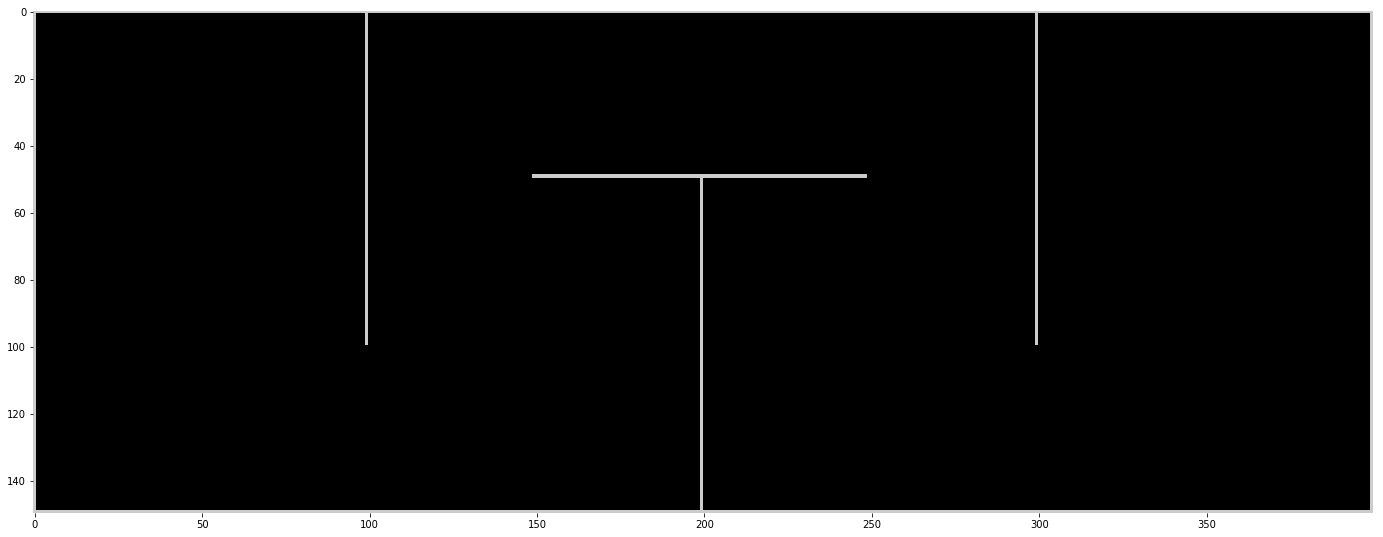

In [10]:
plot_map_2d(map_2d)

In the next three figures, we can visualize the configuration space 4 robot rotations at 0, 45, and 90 degrees respectively. Because our configuration space was acquired using to the convolutions, we can visualize the raw response to provide additional insight in robot collisional intensity, as well as a regionalized cost map.

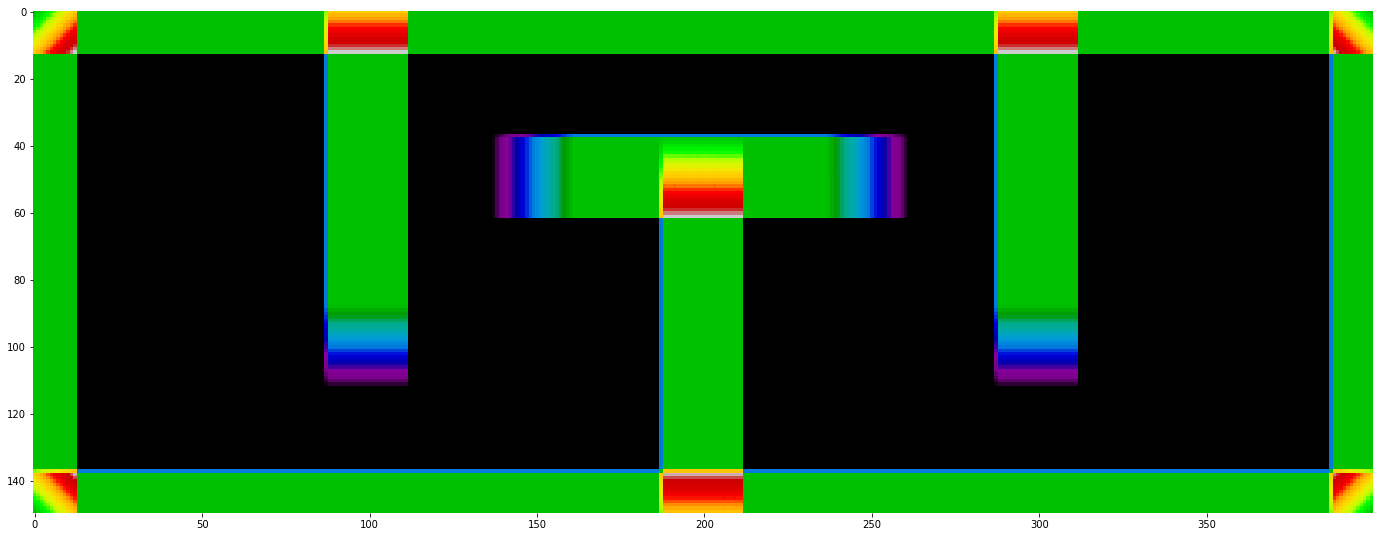

In [11]:
robot_2d_rot = rotate_bound(robot_2d, 0)
config_2d = get_config_2d(map_2d, robot_2d_rot)
# config_2d = np.clip(a=config_2d, a_min=0, a_max=1)
plot_map_2d(config_2d)

 The kernel for the robot’s footprint rotated at 45 degrees.

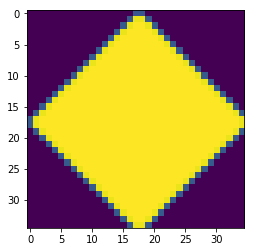

In [12]:
robot_2d_rot = rotate_bound(robot_2d, 45)
plt.imshow(robot_2d_rot)
plt.show()

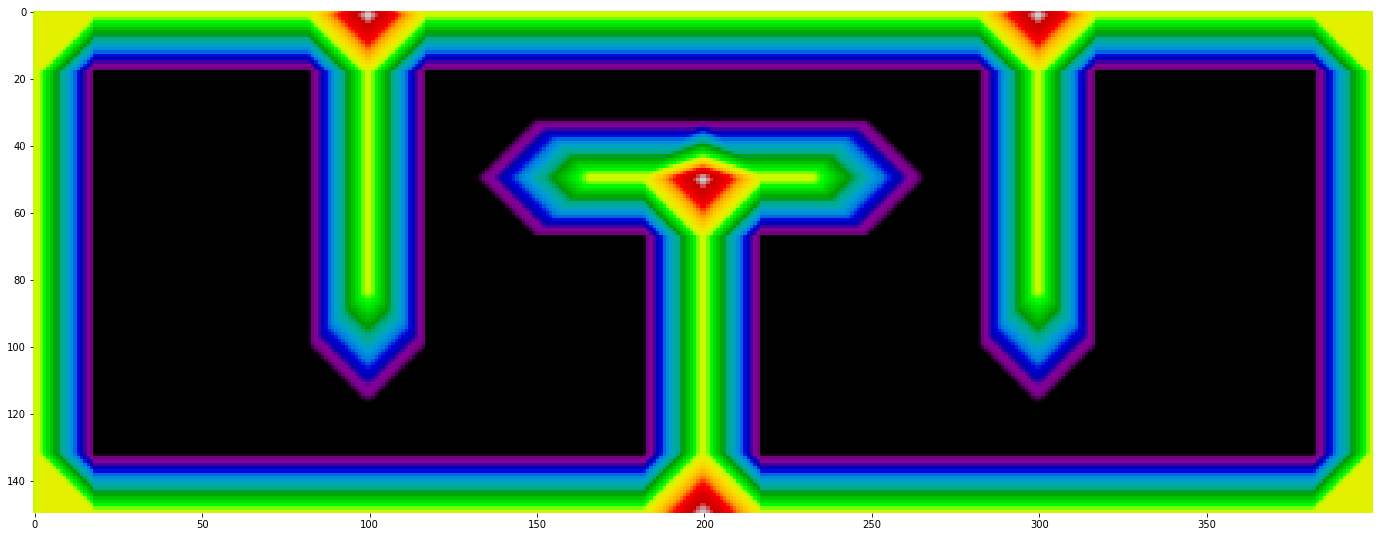

In [13]:
# robot_2d_rot = rotate_bound(robot_2d, 45)
config_2d = get_config_2d(map_2d, robot_2d_rot)
# config_2d = np.clip(a=config_2d, a_min=0, a_max=1)
plot_map_2d(config_2d)

Above is the configuration space for the 45 degree rotation, while below is the space for 90 degree rotation and is visually similar to the 0 degree rotation.

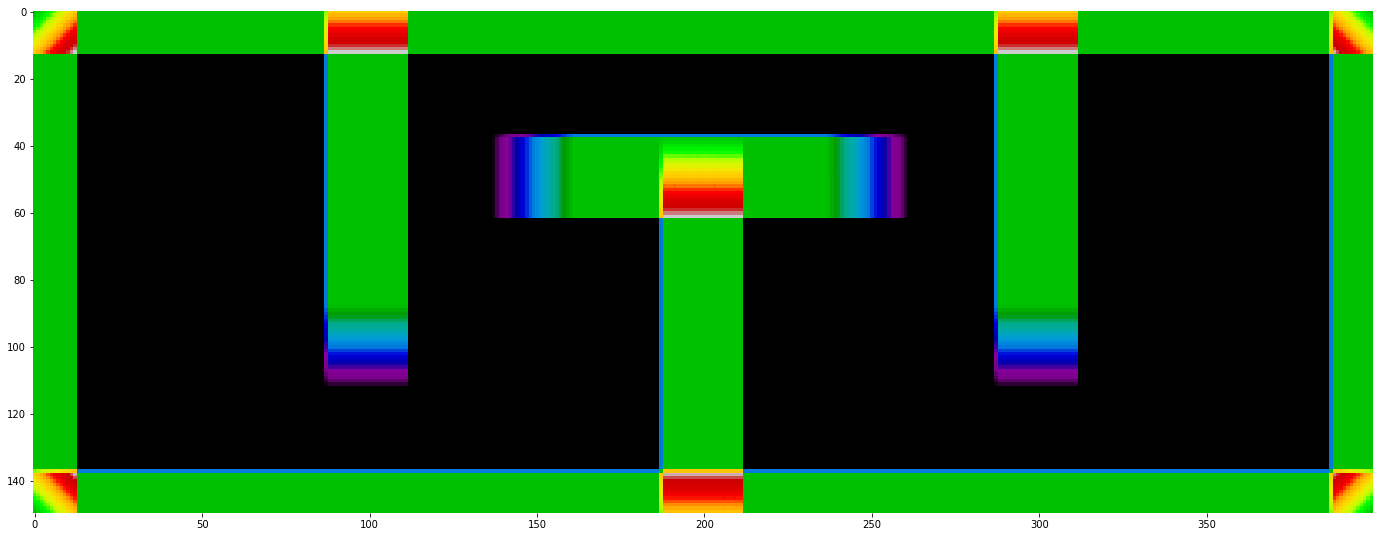

In [14]:
robot_2d_rot = rotate_bound(robot_2d, 90)
config_2d = get_config_2d(map_2d, robot_2d_rot)
# config_2d = np.clip(a=config_2d, a_min=0, a_max=1)
plot_map_2d(config_2d)

Because our robot is rotationally symmetrical across every half pi radians, we can flatten the configuration space across rotations from 0 to 90 degrees by taking the max value along the 3rd axis on our configuration space 3D array representation. This renders the most conservative configuration space where the black region denote all points in the world reference frame that our robot can freely rotate in place.

This is useful for robotic navigation stacks that commonly make use of rotational recovery behaviors when losing localization or determining alternate routes. The astute reader will notice that this is the same result as in taking the  the 2D deconvolution of the world map  with respect to a kernel that is a  simple Circle with a radius defined as the maximum distance a collision point along the robot geometry is with respect to the center of its rotation (assuming our differential drive model).

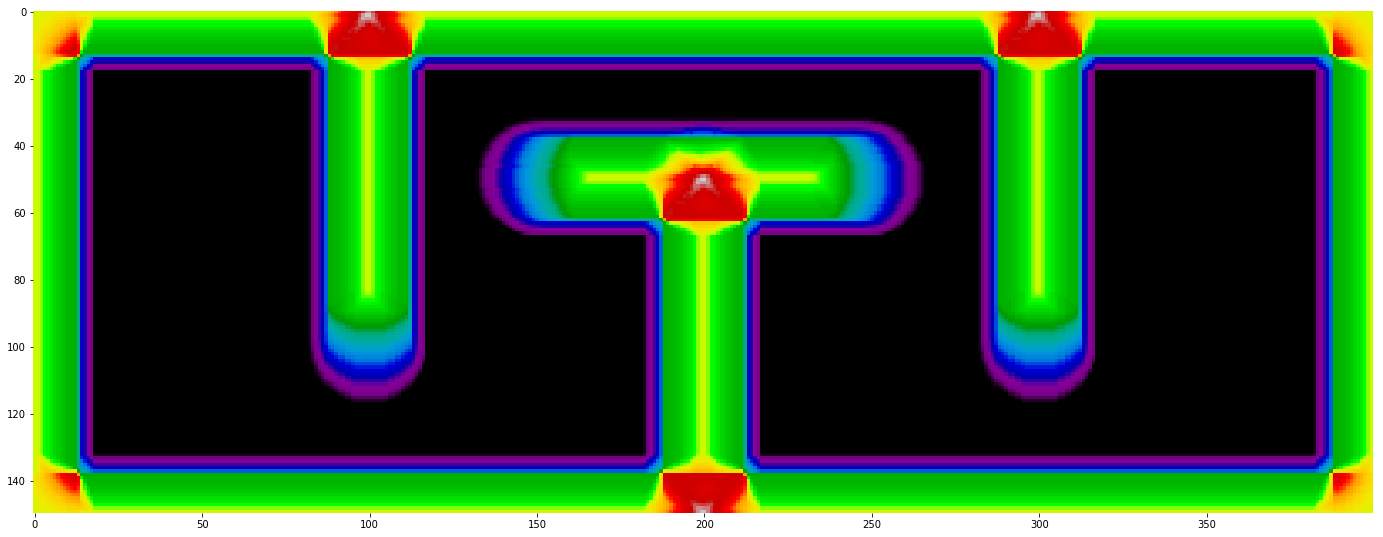

In [15]:
config_space_2d = config_space.max(axis=2)
# config_space_2d = np.clip(a=config_space_2d, a_min=0, a_max=0.001)
plot_map_2d(config_space_2d)

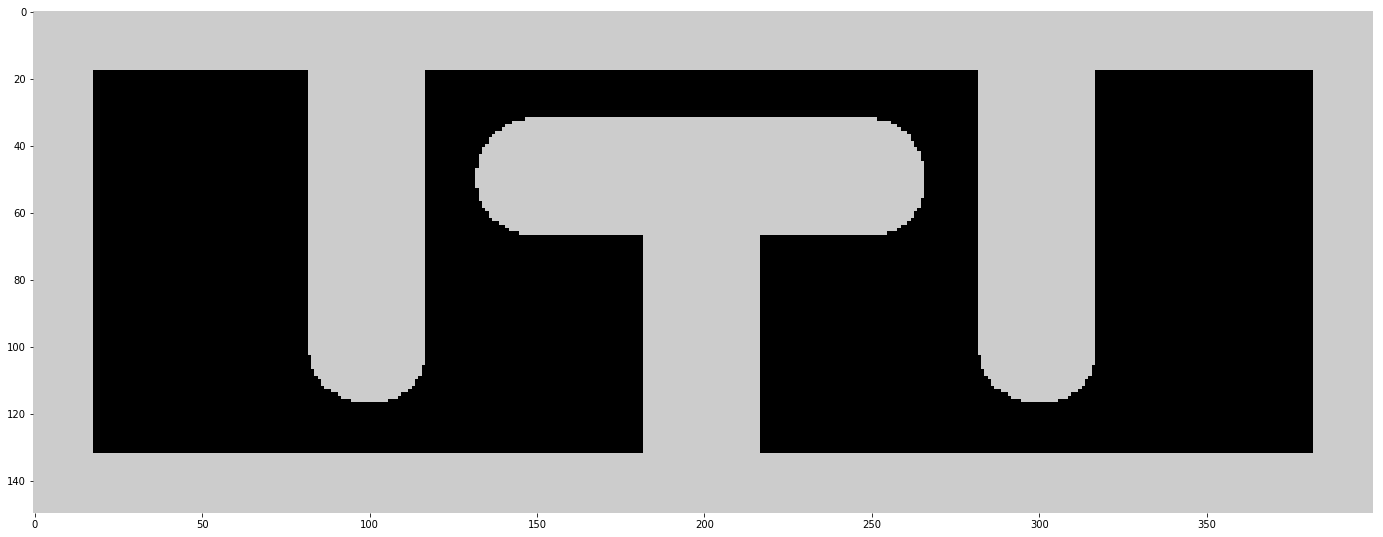

In [16]:
config_space_2d_bool = config_space.max(axis=2)

thresh = 0.001
config_space_2d_bool[config_space_2d < thresh] = 0
config_space_2d_bool[config_space_2d >= thresh] = 1
plot_map_2d(config_space_2d_bool)

We can define a function to sweep through the configuration space in an animated fashion. However this is quite slow using to matplotlib.

In [17]:
import matplotlib
# matplotlib.use('GTKAgg')

def plot_3d(config_space, animated=False, stride=1):
#     config_space = config_space[::stride]
    
    fig, axs = plt.subplots(1,1,figsize=(16,6))
    fig.canvas.draw()
    

    def init():
        axs.imshow(config_space[:,:,0].T, cmap=plt.cm.Spectral_r, interpolation='none')
        plt.axis('off')
        plt.tight_layout()
#         for d in ["left", "top", "bottom", "right"]:
#             axs.spines[d].set_visible(False)
        
        return fig,
    
    def animate(i):
        axs.imshow(config_space[:,:,i].T, cmap=plt.cm.Spectral_r, interpolation='none')
        return fig,
    
    if animated:
        frames = log_progress(range(angle_res), 1)
        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=frames, interval=20, blit=True)
        video = anim.to_html5_video()
        return video
    else:
        init()
        return fig

# empty2_video = plot_3d(config_space, animated=True)
# display(HTML(empty2_video))

You can take a look at animation by viewing figs/config_space.mp4 that depicts the space by moving along the rotational axis for the multi-dimensional configuration space.

In [18]:
from IPython.display import Video
display(Video("figs/config_space.mp4"))

A better alternative is perhaps using pygtgraph and let OpenGL do the heavy lifting for us in rendering the frames.

In [19]:
# import numpy as np
# from pyqtgraph.Qt import QtCore, QtGui
# import pyqtgraph as pg

# # Interpret image data as row-major instead of col-major
# pg.setConfigOptions(imageAxisOrder='row-major')

# app = QtGui.QApplication([])

# ## Create window with ImageView widget
# win = QtGui.QMainWindow()
# win.resize(800,300)
# imv = pg.ImageView()
# win.setCentralWidget(imv)
# win.show()
# win.setWindowTitle('pyqtgraph example: ImageView')

# data = config_space[:,:,:]
# # data = np.clip(a=data, a_min=0, a_max=1)


# ## Display the data and assign each frame a time value from 1.0 to 3.0
# imv.setImage(data.T, xvals=angles)

# # Get the colormap
# colormap = plt.cm.nipy_spectral  # cm.get_cmap("CMRmap")
# colormap._init()
# lut = (colormap._lut * 255).view(np.ndarray)  # Convert matplotlib colormap from 0-1 to 0 -255 for Qt
# imv.imageItem.setLookupTable(lut)

# ptr = 0
# def update():
#     global data, ptr
#     imv.imageItem.updateImage(data[:,:,ptr].T)
#     imv.imageItem.setLookupTable(lut)
#     ptr += 1
#     ptr = ptr % angles.size
# timer = QtCore.QTimer()
# timer.timeout.connect(update)

# ## Start Qt event loop unless running in interactive mode.
# if __name__ == '__main__':
#     import sys
#     if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
#         timer.start(50)
#         QtGui.QApplication.instance().exec_()


We can also use pygtgraph to slice the Configuration space arbitrarily, similarly done with MRI scans.

In [20]:
# import numpy as np
# from pyqtgraph.Qt import QtCore, QtGui
# import pyqtgraph as pg

# app = QtGui.QApplication([])

# ## Create window with two ImageView widgets
# win = QtGui.QMainWindow()
# win.resize(800,800)
# win.setWindowTitle('pyqtgraph example: DataSlicing')
# cw = QtGui.QWidget()
# win.setCentralWidget(cw)
# l = QtGui.QGridLayout()
# cw.setLayout(l)
# imv1 = pg.ImageView()
# imv2 = pg.ImageView()
# l.addWidget(imv1, 0, 0)
# l.addWidget(imv2, 1, 0)
# win.show()

# roi = pg.LineSegmentROI([[10, 64], [120,64]], pen='r')
# imv1.addItem(roi)

# x1 = np.linspace(-30, 10, 128)[:, np.newaxis, np.newaxis]
# x2 = np.linspace(-20, 20, 128)[:, np.newaxis, np.newaxis]
# y = np.linspace(-30, 10, 128)[np.newaxis, :, np.newaxis]
# z = np.linspace(-20, 20, 128)[np.newaxis, np.newaxis, :]
# d1 = np.sqrt(x1**2 + y**2 + z**2)
# d2 = 2*np.sqrt(x1[::-1]**2 + y**2 + z**2)
# d3 = 4*np.sqrt(x2**2 + y[:,::-1]**2 + z**2)
# # data = (np.sin(d1) / d1**2) + (np.sin(d2) / d2**2) + (np.sin(d3) / d3**2)
# data = config_space[:,:,:]

# def update():
#     global data, imv1, imv2
#     d2 = roi.getArrayRegion(data, imv1.imageItem, axes=(1,2))
#     imv2.setImage(d2)
    
# roi.sigRegionChanged.connect(update)


# ## Display the data
# imv1.setImage(data)
# imv1.setHistogramRange(-0.01, 0.01)
# imv1.setLevels(-0.003, 0.003)

# update()

# ## Start Qt event loop unless running in interactive mode.
# if __name__ == '__main__':
#     import sys
#     if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
#         QtGui.QApplication.instance().exec_()

Lastly we can export the occupancy grid from our configuration workspace and to a three dimensional Point cloud. Obviously this only works because of the 2D dimension of our initial world frame with the additional dimension of rotation. However the same slicing technique, as above, could be used to introspect the configuration space for higher dimensions.

In [21]:
# from plyfile import PlyData, PlyElement
# data = np.clip(a=config_space, a_min=0, a_max=1)
# points = np.asarray(np.where(data == 1)).T
# vertex = np.array(list(map(tuple, points)), dtype=[('x', 'u2'), ('y', 'u2'), ('z', 'u2')])
# el = PlyElement.describe(vertex, 'config_space')
# PlyData([el]).write('config_space.ply')

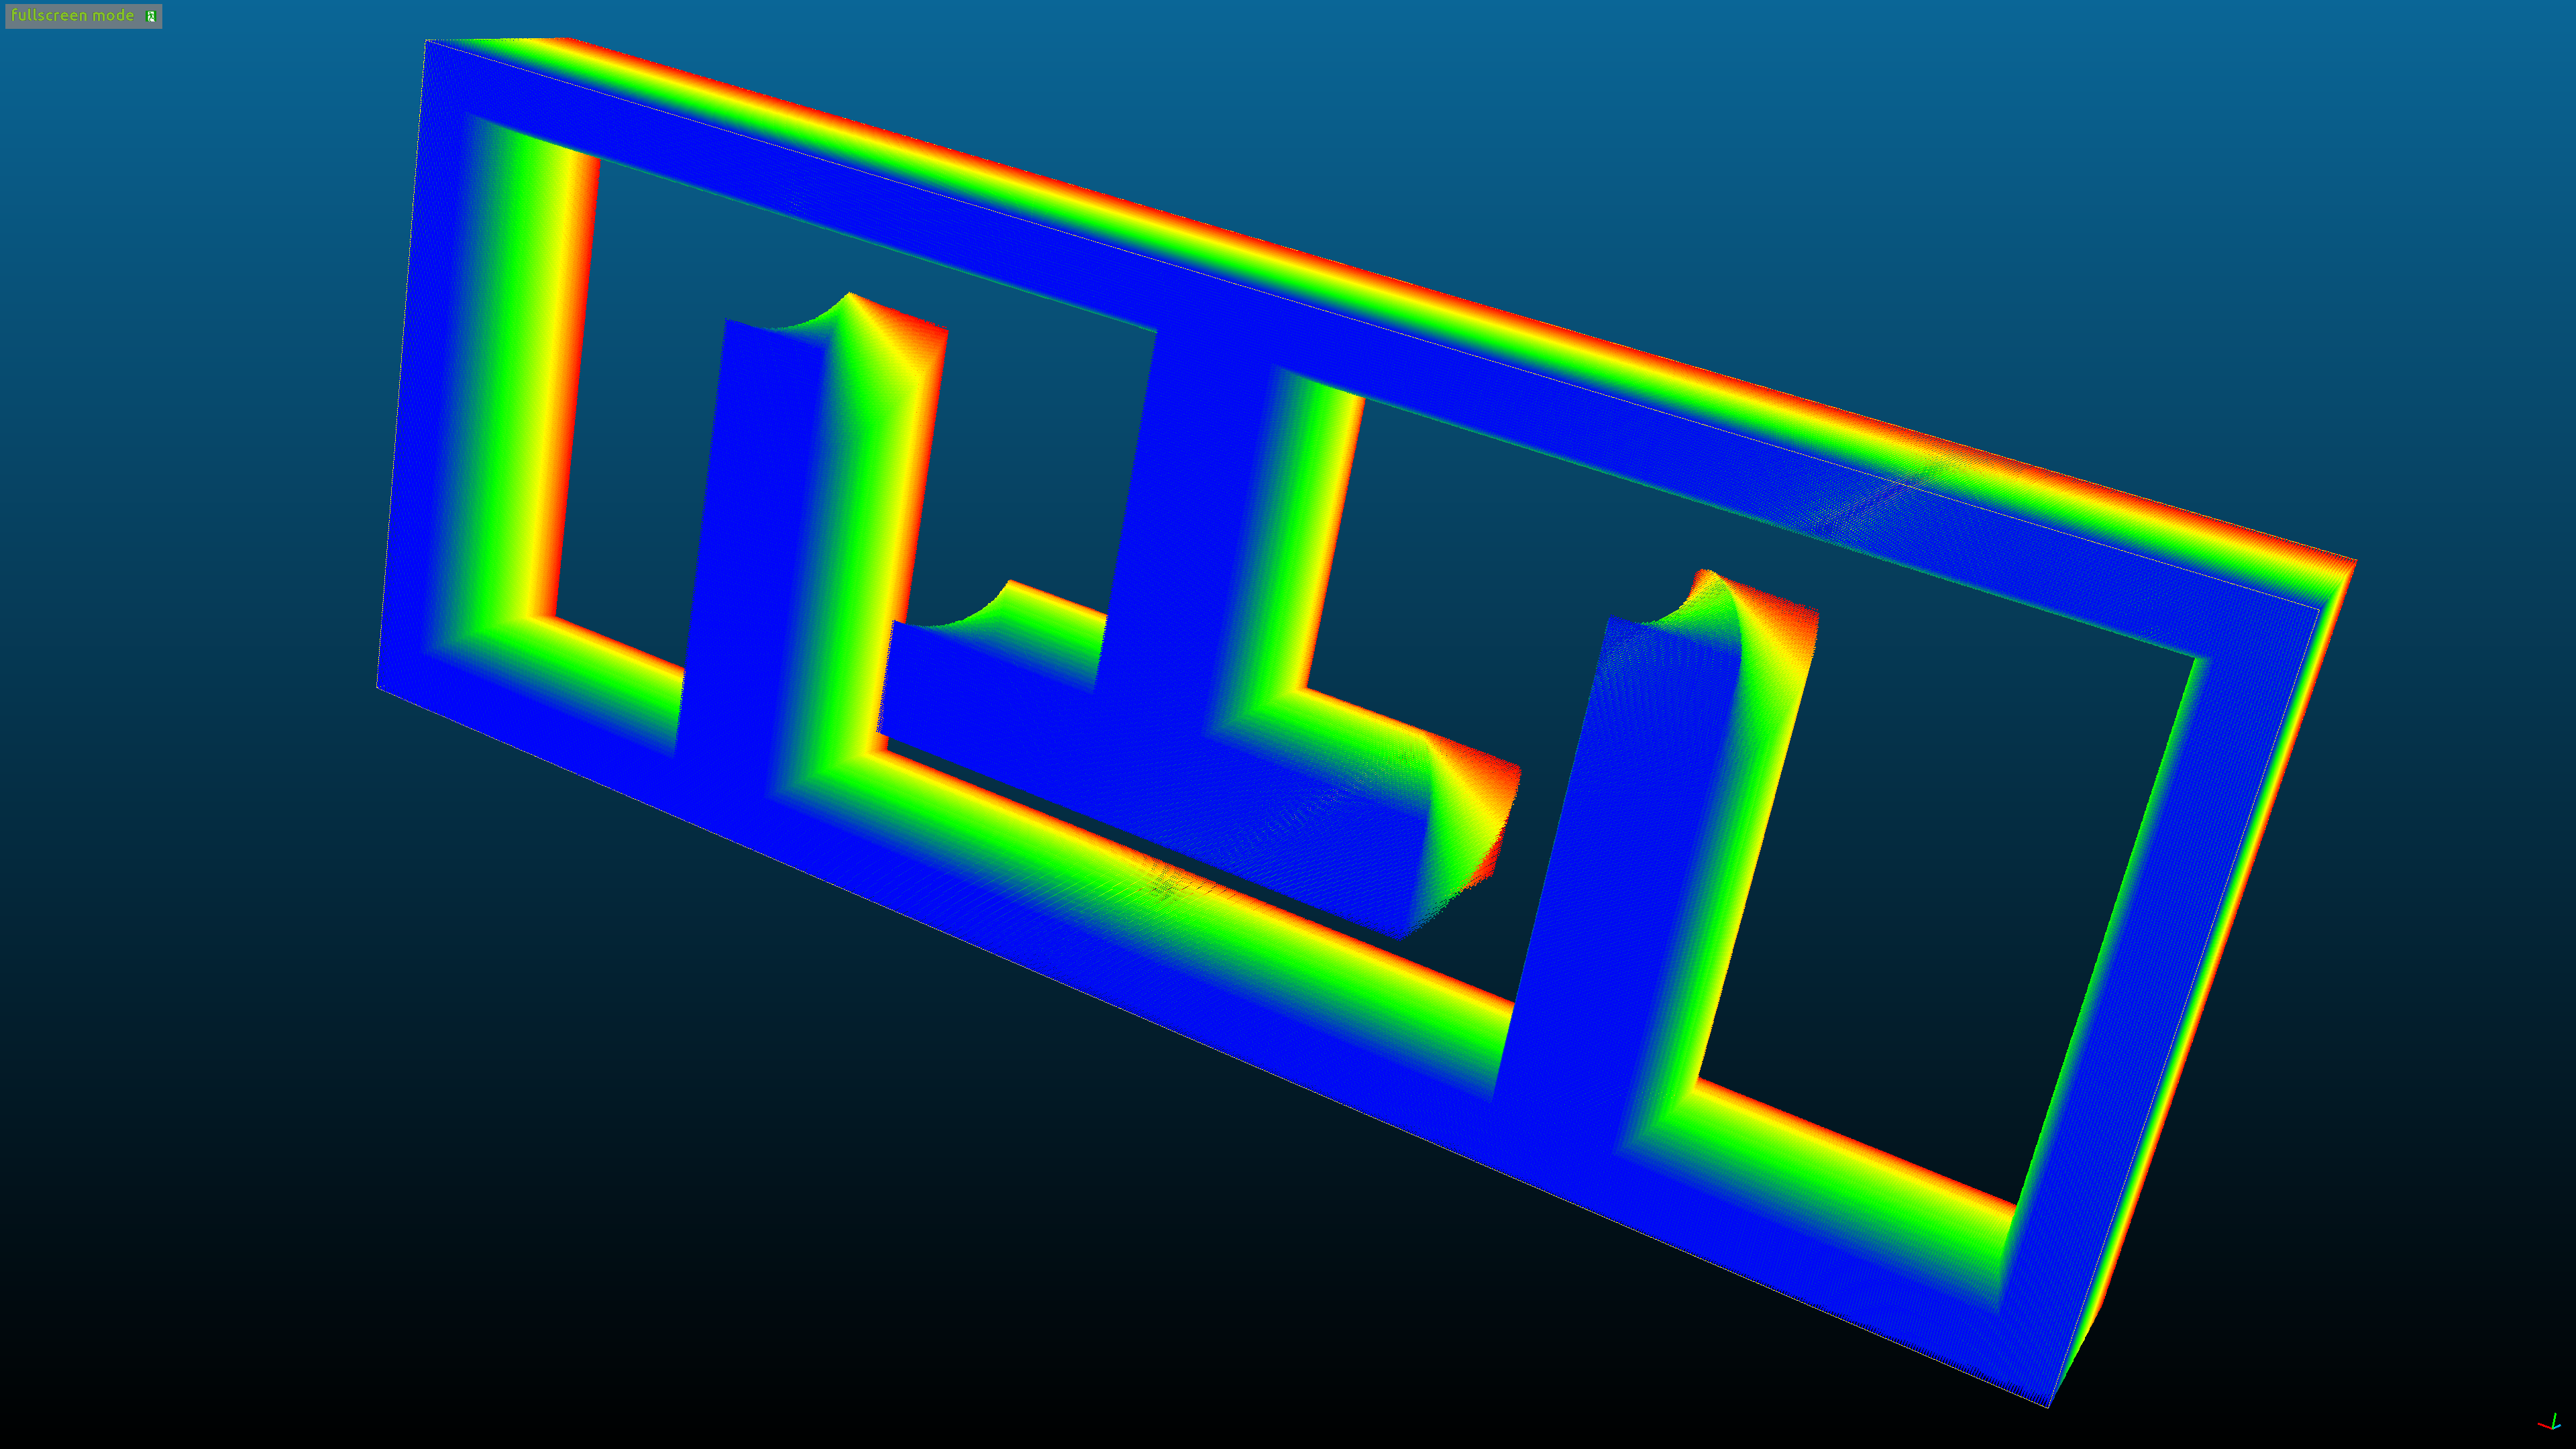

In [22]:
from IPython.display import Image
display(Image(filename="figs/config_space.png"))

## 2. Greedy Search

For simple search, we can use basic methods such as A*, or due to the grid-based regularity of the search domain, we can leverage more advanced methods such as Jump Point Search (JPS). JPS take advantage of the grid based symmetry by recursively traversing in the direction of expansion until a stop condition is reached. Stop conditions for JPS mainly pertain to instances where symmetry along  either side of the expansion direction is broken. This stop point is then used as a seed for the expansion point. JPS can also leverage heuristics same as A*, where our heuristic here is made admissible by utilizing the euclidean distance between the expansion point and goal.

Here will simply export our configuration space into a yaml file suitable for a C++ JPS implementation to search through. We then can read back the solved paths and compare A* to JPS. The source code for this executable can be found here at [this fork](  https://github.com/ruffsl/jps3d/blob/c8205c6d94d4cefea74fd8f63bbf45e7613f0270/test/test_planner_2d.cpp)

In [23]:
import oyaml as yaml
import collections

def search2yaml(start, goal, map_grid, path):
    meta = []
    meta.append({'start': start[::-1].tolist()})
    meta.append({'goal': goal[::-1].tolist()})
    meta.append({'origin': np.zeros(len(map_grid.shape), dtype=np.int).tolist()})
    meta.append({'dim': list(map_grid.shape[::-1])})
    meta.append({'resolution': 1})
    meta.append({'data': map_grid.flatten().astype(np.int).tolist()})
    with open(path, 'w') as outfile:
        yaml.dump(list(meta), outfile)

An attempt was made to search the full configuration space using JPS in 3D, as exampled [here](https://github.com/sikang/jps3d/pull/4),  however because we normally want to optimize for distance traveled within the workspace as opposed to the configuration space, the cost for traversing the configuration space must also reflect this flexibility. Doing this would require a zero edge cost and traversercing the configuration space through the rotational dimension, permitting the robot to freely rotate on its axis without penalty. Additionally, because the robot here is not holonomic, we can’t necessarily move in every direction at any given point in the configuration space because of the restriction of the robot dynamics. This would necessitate an alternate formulation of the discrete configuration space representation that would not correspond to a regular lattice like graph.

Thus, for simplicity and runtime complexity using python functions, the configuration space has been compressed or projected into a 2D subspace for quick planning. In practice this could potentially remove all  potential solutions,  however in this case we can visually verify that even the most conservative representation is still adequately solvable.

In [24]:
start = (np.array([50,50])/scale).astype(np.int)
goal = (np.array([750,250])/scale).astype(np.int)

config_space_2d_bool_path = '/tmp/config_space_2d_bool.yaml'
search2yaml(start=start, goal=goal, map_grid=config_space_2d_bool, path=config_space_2d_bool_path)

In [25]:
jps_build_path = '/home/ruffsl/git/sikang/jps3d/build'
output_dir = '/tmp/'

In [26]:
%%script env JPS_BUILD_PATH="$jps_build_path" YAML_FILE="$config_space_2d_bool_path" OUTPUT_DIR="$output_dir" bash

cd $JPS_BUILD_PATH
./test_planner_2d $YAML_FILE $OUTPUT_DIR

start: 25 25
goal: 125 375
origin: 0 0
dim: 150 400
resolution: 1
JPS PLANNER VERBOSE ON
Start: 25 25
Goal:  125 375
Epsilon:  1
Goal Reached!!!!!!

goal g: 538.232539, h: 0.000000!
Expand [841] nodes!
JPS Planner takes: 0.000000 ms
JPS Path Distance: 538.232539
AStar Planner takes: 12.000000 ms
AStar Path Distance: 538.232539


In [27]:
import os

def read_solved_paths(output_dir):
    path_jps_file = os.path.join(output_dir, 'path_jps.csv')
    path_astar_file = os.path.join(output_dir, 'path_astar.csv')
    path_jps = np.genfromtxt(path_jps_file, delimiter=',', dtype=np.int).T
    path_astar = np.genfromtxt(path_astar_file, delimiter=',', dtype=np.int)[::-1].T
    path_jps[[0, 1],:] = path_jps[[1, 0],:]
    path_astar[[0, 1],:] = path_astar[[1, 0],:]
    return path_jps, path_astar

From the details printed above, we can see the distances of the two paths found using A* and JPS are equivalent in length, however JPS took significantly less time to find the optimal grid based path for this particular subspace.

However, because of the Triangle inequality, we know the paths generated from our Manhattan based configuration space will always be of a longer distance than that of pure continuous euclidean solutions. The distance here however can provide a suitable upper bound for any euclidean based methods such as those using high-resolution visibility graphs.

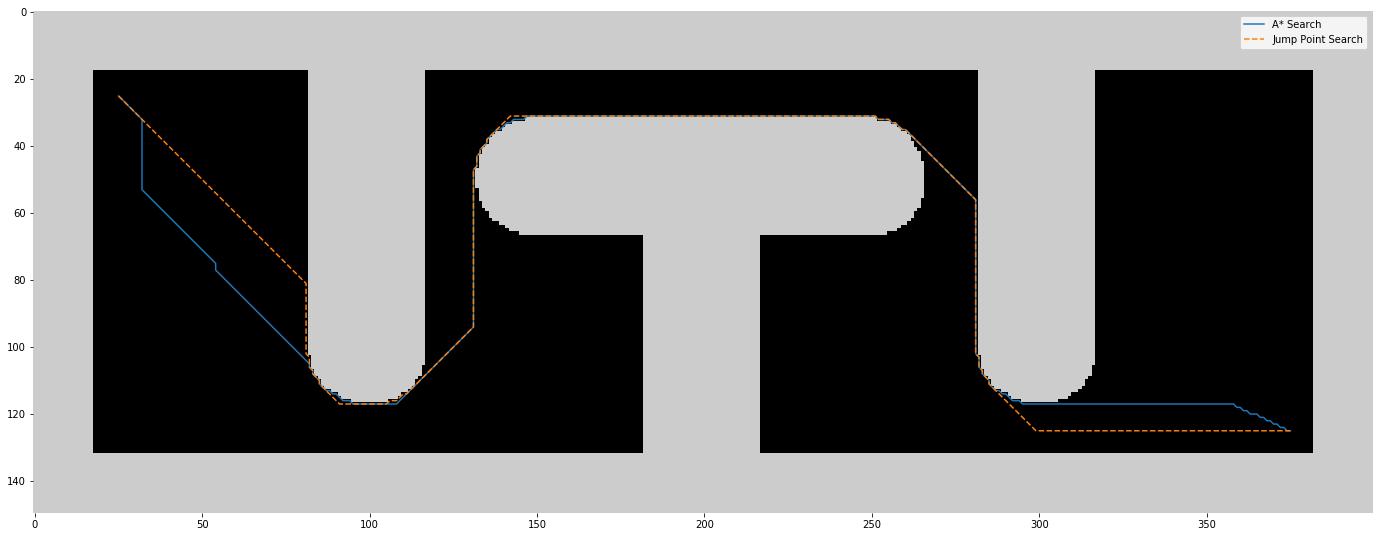

In [28]:
path_jps, path_astar = read_solved_paths(output_dir)

fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

ax.plot(path_astar[0], path_astar[1], label="A* Search")
ax.plot(path_jps[0], path_jps[1], '--', label="Jump Point Search")
plt.legend()
plt.show()

To tighten this upper bound of optimal path distance even further, we can instead  consider the more optimistic projection of the configuration subspace by convolving with only the inner diameter of the robot. The intuition here being: as would a race car driver hug the inner corner of any turn to minimize distance travel along a route, so too should the differential robot hug the inner wall of obstacles when circumnavigating corners. However, because our traversal of the discrete configuration space is limited to bearings along long quarter pie increments, we know this solution to still be suboptimal. A geometric path planner using euclidean space would most likely return a path with ray traced trajectories that tangentially intersect the turning points show here.

In [29]:
a, b = int(rwidth/2), int(rwidth/2)
n = rwidth
r = int(rwidth/2)
y,x = np.ogrid[-a:n-a, -b:n-b]
mask = x*x + y*y <= r*r

optimistic_robot_2d = np.zeros((n, n))
optimistic_robot_2d[mask] = 1

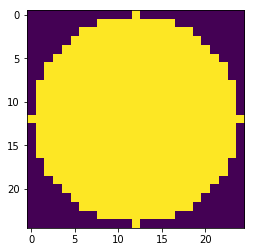

In [30]:
plt.imshow(optimistic_robot_2d)
plt.show()

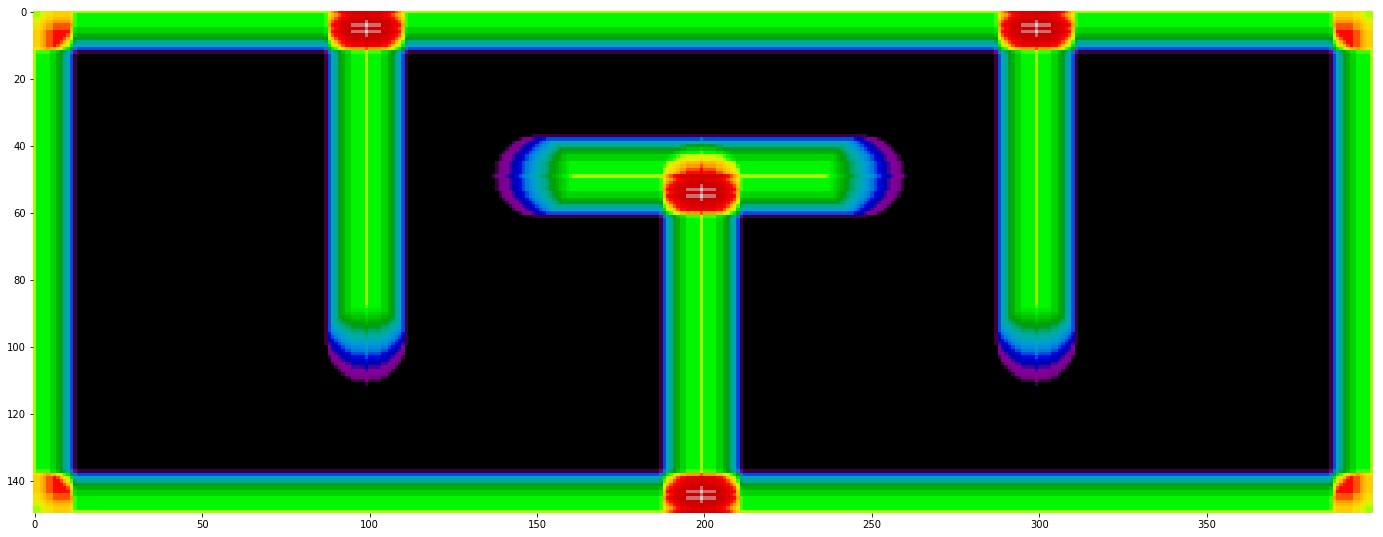

In [31]:
optimistic_config_space_2d = get_config_2d(map_2d, optimistic_robot_2d)
plot_map_2d(optimistic_config_space_2d)


optimistic_config_space_2d_bool = optimistic_config_space_2d.copy()
optimistic_config_space_2d_bool[optimistic_config_space_2d < thresh] = 0
optimistic_config_space_2d_bool[optimistic_config_space_2d >= thresh] = 1
# plot_map_2d(optimistic_config_space_2d_bool)

In [32]:
optimistic_config_space_2d_bool_path = '/tmp/optimistic_config_space_2d_bool.yaml'
search2yaml(start=start, goal=goal, map_grid=optimistic_config_space_2d_bool, path=optimistic_config_space_2d_bool_path)

In [33]:
%%script env JPS_BUILD_PATH="$jps_build_path" YAML_FILE="$optimistic_config_space_2d_bool_path" OUTPUT_DIR="$output_dir" bash

cd $JPS_BUILD_PATH
./test_planner_2d $YAML_FILE $OUTPUT_DIR

start: 25 25
goal: 125 375
origin: 0 0
dim: 150 400
resolution: 1
JPS PLANNER VERBOSE ON
Start: 25 25
Goal:  125 375
Epsilon:  1
Goal Reached!!!!!!

goal g: 503.587878, h: 0.000000!
Expand [718] nodes!
JPS Planner takes: 1.000000 ms
JPS Path Distance: 503.587878
AStar Planner takes: 19.000000 ms
AStar Path Distance: 503.587878


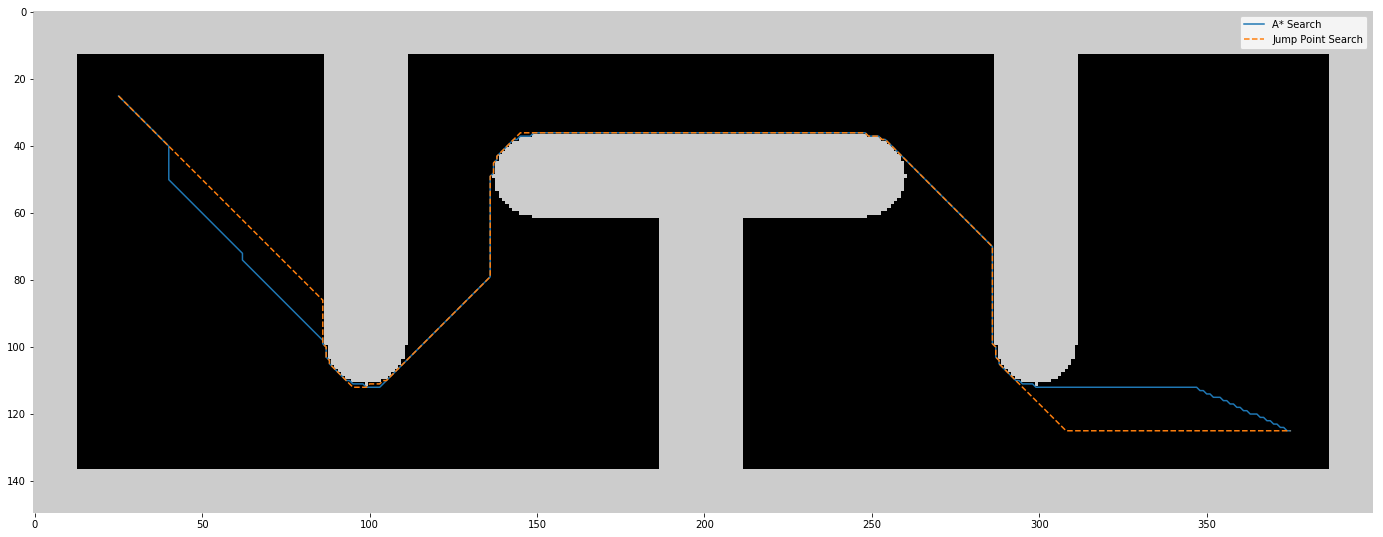

In [34]:
path_jps, path_astar = read_solved_paths(output_dir)

fig = plot_map_2d(optimistic_config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

ax.plot(path_astar[0], path_astar[1], label="A* Search")
ax.plot(path_jps[0], path_jps[1], '--', label="Jump Point Search")
plt.legend()
plt.show()

## 3. Safest Path

Computing the safest is path through our workspace environment will in this case equate as being the trajectory that is  maximally distant from all nearby obstacles. Essentially this necessitates computing the voronoi partitions for the empty regions in the work space. We can then travers the set of points generated from this tessellation as it provides us a simplistic roadmap. We then need only find the closest decomposed points to both the start and the goal. As a final check, we can sample the resulting trajectory using our configuration space as a collisions look up.

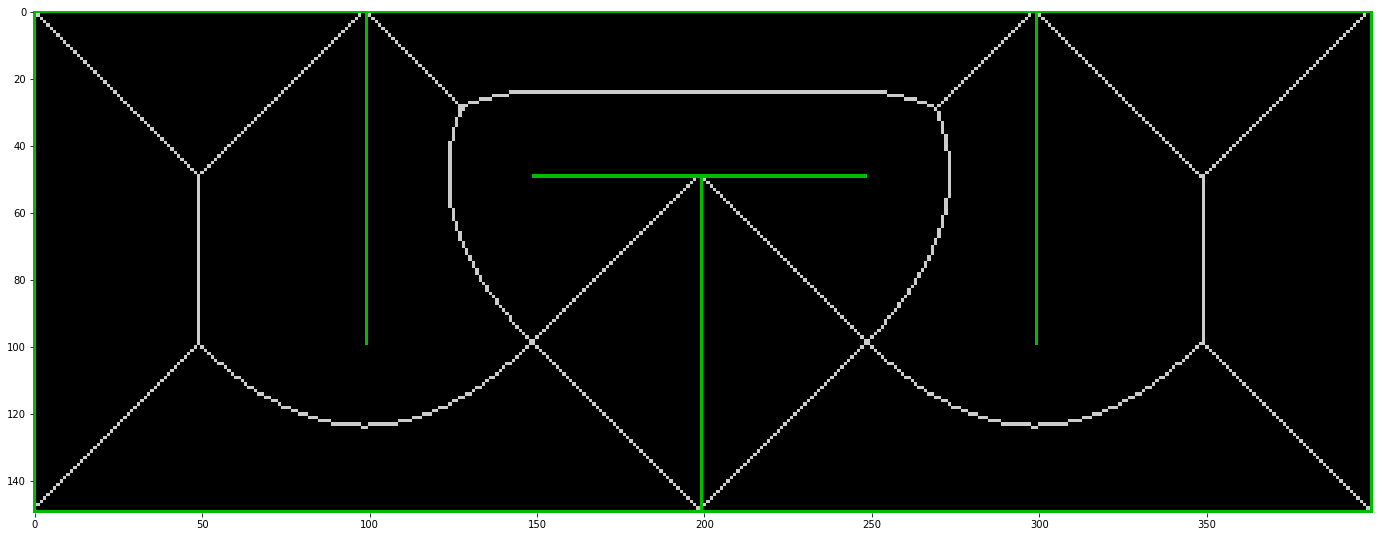

In [35]:
points = np.asarray(np.where(map_2d == 1)).T
vor = scipy.spatial.Voronoi(points)

vertices = vor.vertices[::1].T.astype(int)
map_2d_vert = map_2d.copy()
map_2d_vert[vertices[0],vertices[1]] = 2
map_2d_vert[map_2d == 1] = 1

plot_map_2d(map_2d_vert)

In [36]:
map_2d_vert_bool = map_2d_vert.copy()
map_2d_vert_bool[map_2d_vert == 2] = 0
map_2d_vert_bool[map_2d_vert != 2] = 1

map_2d_vert_bool_path = '/tmp/map_2d_vert_bool.yaml'
search2yaml(start=start, goal=goal, map_grid=map_2d_vert_bool, path=map_2d_vert_bool_path)

In [37]:
%%script env JPS_BUILD_PATH="$jps_build_path" YAML_FILE="$map_2d_vert_bool_path" OUTPUT_DIR="$output_dir" bash

cd $JPS_BUILD_PATH
./test_planner_2d $YAML_FILE $OUTPUT_DIR

start: 25 25
goal: 125 375
origin: 0 0
dim: 150 400
resolution: 1
JPS PLANNER VERBOSE ON
Start: 25 25
Goal:  125 375
Epsilon:  1
Goal Reached!!!!!!

goal g: 669.470129, h: 0.000000!
Expand [879] nodes!
JPS Planner takes: 0.000000 ms
JPS Path Distance: 669.470129
AStar Planner takes: 0.000000 ms
AStar Path Distance: 669.470129


From the results shown we can see that the trajectory following the voronoi partitioning is well far away from any congestion points with some margin of room to spare. This could be useful for any kind of trajectory controller that has a good amount of play and its set point pursuit, permitting some amount of deviance from the setpoint  trajectory to enable higher speed dynamics. 

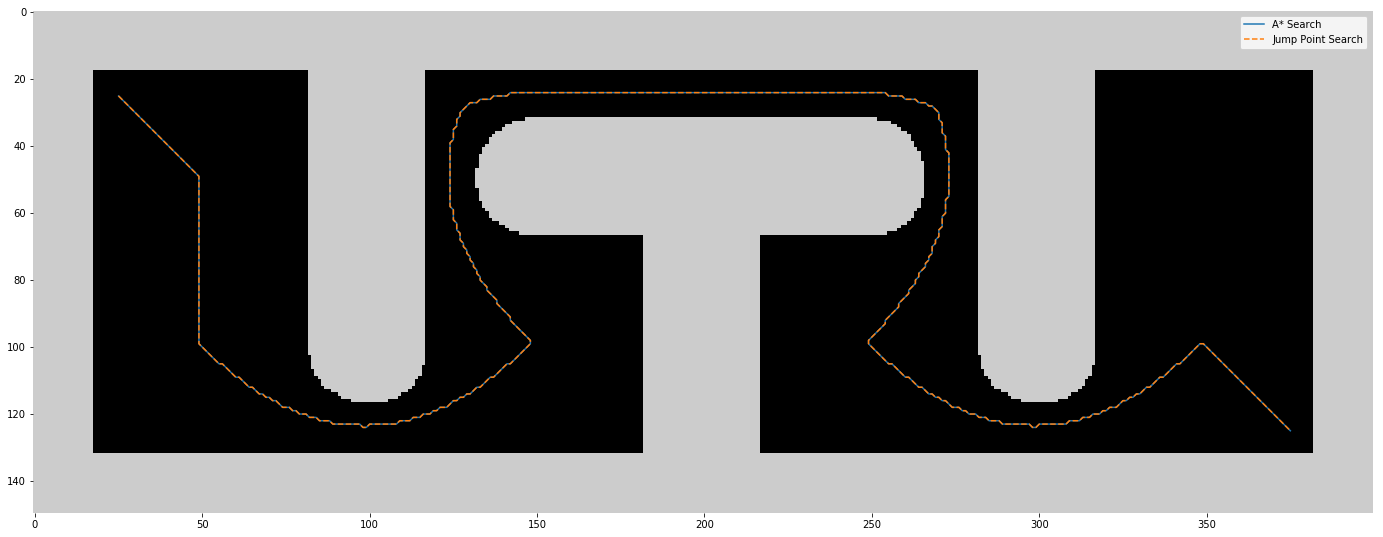

In [38]:
path_jps, path_astar = read_solved_paths(output_dir)

fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

ax.plot(path_astar[0], path_astar[1], label="A* Search")
ax.plot(path_jps[0], path_jps[1], '--', label="Jump Point Search")
plt.legend()
plt.show()

## 4. Probabilistic Road Maps

Position for meditation and probabilistic roadmaps, will simply sample the unoccupied free space in the discrete projection of the configuration subspace, Then attempt to connect a road map between unobstructed points and then finally search the graph for a suitable trajectory.

We can simplify the sampling method by flattening the projected subspace into a 1D array, and then sampling from that array using the occupancy values as probabilistic weights of the point to be sampled from.

In [39]:
def sample_points(map_2d, n_sample):
    map_2d_flat = map_2d.flatten()
    
    map_2d_p = ((map_2d.flatten()-1)*-1).astype(np.int)
    map_2d_p = map_2d_p/map_2d_p.sum()
    map_2d_ix = np.arange(0, map_2d_flat.size)

    samples = np.random.choice(map_2d_ix, n_sample, replace=False, p=map_2d_p)
    samples = np.array(np.unravel_index(samples, map_2d.shape))

    return samples

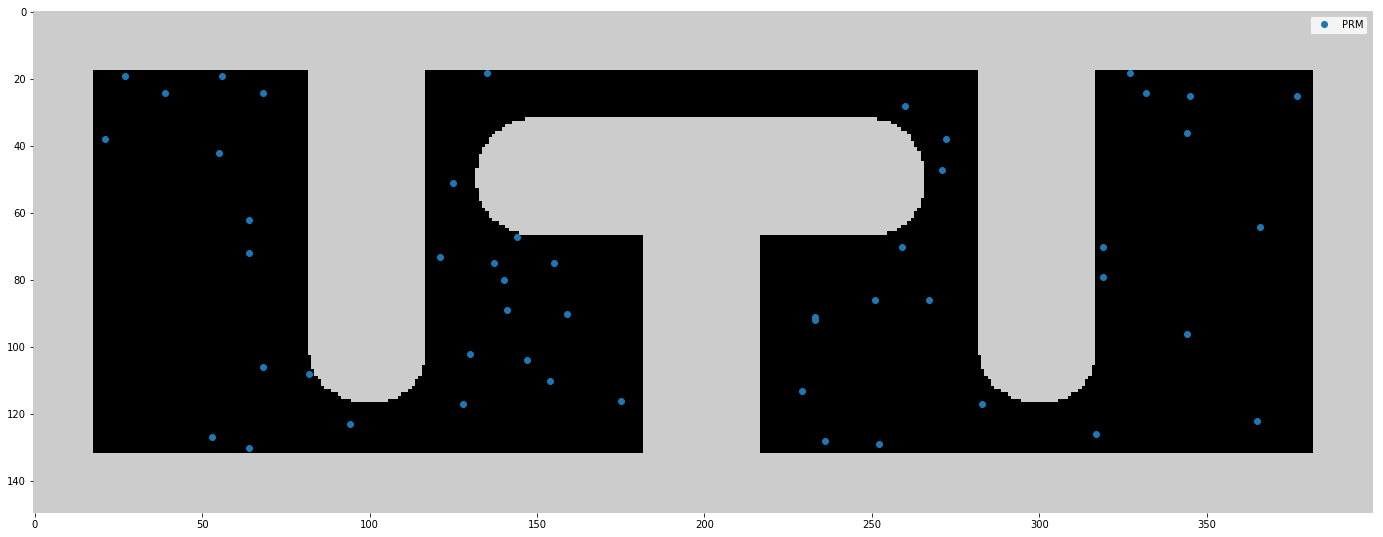

In [58]:
n_samples = 50
samples = sample_points(config_space_2d_bool, n_samples)

fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

ax.plot(samples[0], samples[1], 'o', label="PRM")
plt.legend()
plt.show()

Now that we have a number of samples, will construct a fully connected graph from the samples, then traverse along their edges to ensure they are  unobstructed, and if not simply prune them from the roadmap.

In [59]:
from skimage import measure
import networkx as nx
import heapq

In [60]:
def norm_by_min_max(array):
    array = array - array.min()
    array = array/array.max()
    array = array/array.sum()
    return array

def sample_edges(G, n_sample, attribute='distance'):
    edgelist, edge_distances = zip(*nx.get_edge_attributes(G,attribute).items())
    edges_p = np.array(edge_distances)
    edges_p = norm_by_min_max(edges_p)
    edges_ix = np.arange(0, len(edgelist))

    samples = np.random.choice(edges_ix, n_sample, replace=False, p=edges_p)
    return samples

def sample_edges_sorted(G, n_sample, attribute='distance'):
    edgelist, edge_distances = zip(*nx.get_edge_attributes(G,attribute).items())
    edge_distances = np.array(edge_distances)
    edges_ix = np.arange(0, len(edgelist))
    
    samples = heapq.nlargest(n_sample, edges_ix, edge_distances.take)
    return samples

def prune_graph_edges(G, n_prune, prune_method):
    samples = prune_method(G, n_prune)
    edges = np.array(G.edges())
    edges = edges[samples]
    for edge in edges:
        u, v = tuple(edge[0]), tuple(edge[1])
        G.remove_edge(u, v)
    return G

In [61]:
def distance(u, v):
    return np.linalg.norm(np.array(u)-np.array(v))

def build_prm_graph(map_2d, samples, n_prune, prune_method=sample_edges):
    G = nx.complete_graph(samples.shape[1])
    print("Number of edges when completely connected: ", len(G.edges()))
    
    keys = tuple(map(tuple, samples.T))
    mapping = dict(zip(G.nodes, keys))
    G = nx.relabel_nodes(G, mapping)
    
    for u, v, data in G.edges(data=True):
        data['color'] = 'blue'
        data['distance'] = distance(u, v)
    G = prune_graph_edges(G, n_prune, prune_method)
    
    
    G_temp = G.copy()
    
    G_edges = G_temp.edges()
    print("Number of edges after pruning: ", len(G.edges()))
    for edge in G_edges:
        trajectory = measure.profile_line(map_2d, edge[0], edge[1])
        if trajectory.any():
            G.remove_edge(*edge)

    for node, data in G.nodes(data=True):
        data['color'] = 'purple'
        data['pos'] = node
    return G

In [62]:
ratio_prune = 0
# ratio_prune = 0.98
n_prune = int((n_samples*(n_samples-1)/2)*ratio_prune)
G = build_prm_graph(config_space_2d_bool, samples, n_prune)

Number of edges when completely connected:  1225
Number of edges after pruning:  1225


Notice that the number of edges for a  completely connected graph is $\frac{n \cdot (n - 1)}{2}$, where in is the number nodes. For $n=50$, we find the number of edges to be 1225. This Exponential of complexity will soon catch up with us as we increase the number of samples for a roadmap. Because collision checking is done on an edge by edge basis via boolean logic across profile lines cutting the Configuration Subspace,  reducing the number of edges later will be important and minimizing this bottleneck to  achieve higher-density road maps.

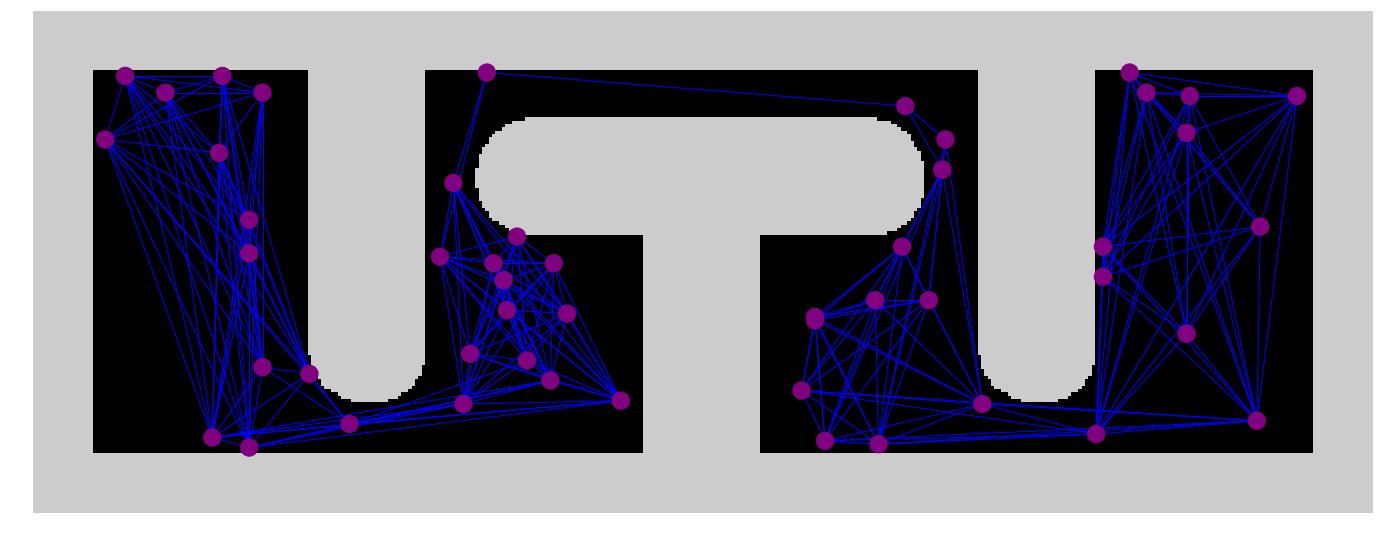

In [63]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

pos = nx.get_node_attributes(G,'pos')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())
nodelist, node_color = zip(*nx.get_node_attributes(G,'color').items())

nx.draw(G, pos=pos, ax=ax, edgelist=edgelist, edge_color=edge_color, node_color=node_color)
plt.show()

In [64]:
from scipy import spatial

In [65]:
def find_closest_open_path(point, tree, map_2d, G):
    dists, indexs = tree.query(x=point, k=len(G.nodes()))
    for index in indexs:
        query = tree.data[index]
        trajectory = measure.profile_line(map_2d, point, query)
        if not trajectory.any():
            return query
    raise ValueError("No open path found")

def query_prm(start, goal, map_2d, G):
    start = tuple(start)
    goal = tuple(goal)
    G = G.copy()
    nodes = G.nodes()
    tree = spatial.KDTree(nodes)
    graph_start = tuple(find_closest_open_path(start, tree, map_2d, G))
    graph_goal = tuple(find_closest_open_path(goal, tree, map_2d, G))
    G.add_node(start, pos=start, color='green')
    G.add_node(goal, pos=goal, color='red')
    G.add_edge(start, graph_start, distance=distance(start, graph_start))
    G.add_edge(goal, graph_goal, distance=distance(goal, graph_goal))
    
    path = nx.astar_path(G, source=start, target=goal, heuristic=distance, weight='distance')
    G_path = G.subgraph(path)
    for u, v, data in G_path.edges(data=True):
        data['color'] = 'orange'
    for node, data in G_path.nodes(data=True):
        if node not in [start, goal]:
            data['color'] = 'orange'
    length = nx.astar_path_length(G, source=start, target=goal, heuristic=distance, weight='distance')
    return G, path, length

To use and search the road map, We simply find the respective nearest  unobstructed PRM neighbors for the start and goal to attach them to the graph, Then simply use heuristic based search  method such as A* to traverse the graph and return a shortest path.

In [66]:
G, path, length_prm_50 = query_prm(start, goal, map_2d=config_space_2d_bool, G=G)

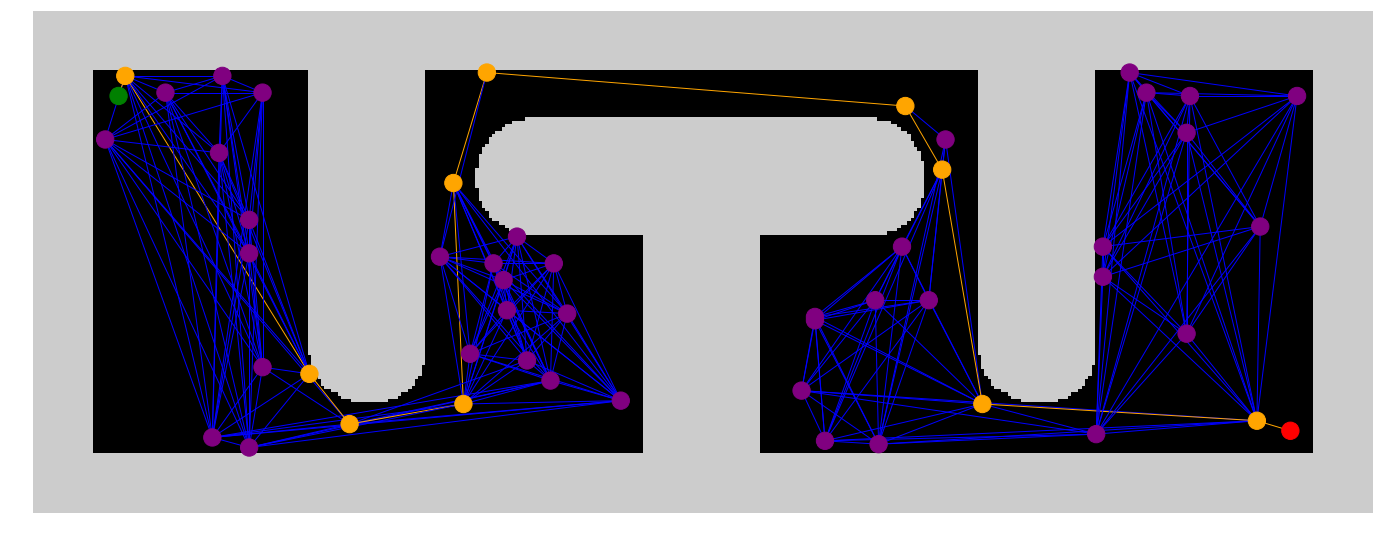

PRM Length:  576.2000283301505


In [67]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

pos = nx.get_node_attributes(G,'pos')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())
nodelist, node_color = zip(*nx.get_node_attributes(G,'color').items())

nx.draw(G, pos=pos, ax=ax, edgelist=edgelist, edge_color=edge_color, node_color=node_color)
plt.show()
print("PRM Length: ", length_prm_50)

When considering the probabilistic roadmap using twice as many samples, we know that the number of edges will roughly quadruple. To mitigate this we can probabilistically prune the complete graph by randomly removing edges, where the  likelihood of removing an edge is  directly proportional to its length. We also finesse this distribution weights a little to ensure that shorter edges have a lesser chance of removal.

The intuition here is that longer edges have a higher likelihood of  intersecting obstacles, and are thus less likely to be unobstructed and can be preemptively culled from the politician without  wasting time in checking. This has the potential drawback of increasing the likelihood that the roadmap graph is disjoint, however the complexity savings easily afford us the means to  increase the sampling density to compensate. Here we’ll use a dropout of 50% to speed up the quiry.

In [71]:
n_samples = 100
samples = sample_points(config_space_2d_bool, n_samples)

ratio_prune = 0
ratio_prune = 0.50
n_prune = int((n_samples*(n_samples-1)/2)*ratio_prune)
G = build_prm_graph(config_space_2d_bool, samples, n_prune)

G, path, length_prm_100_prob_prune = query_prm(start, goal, map_2d=config_space_2d_bool, G=G)

Number of edges when completely connected:  4950
Number of edges after pruning:  2475


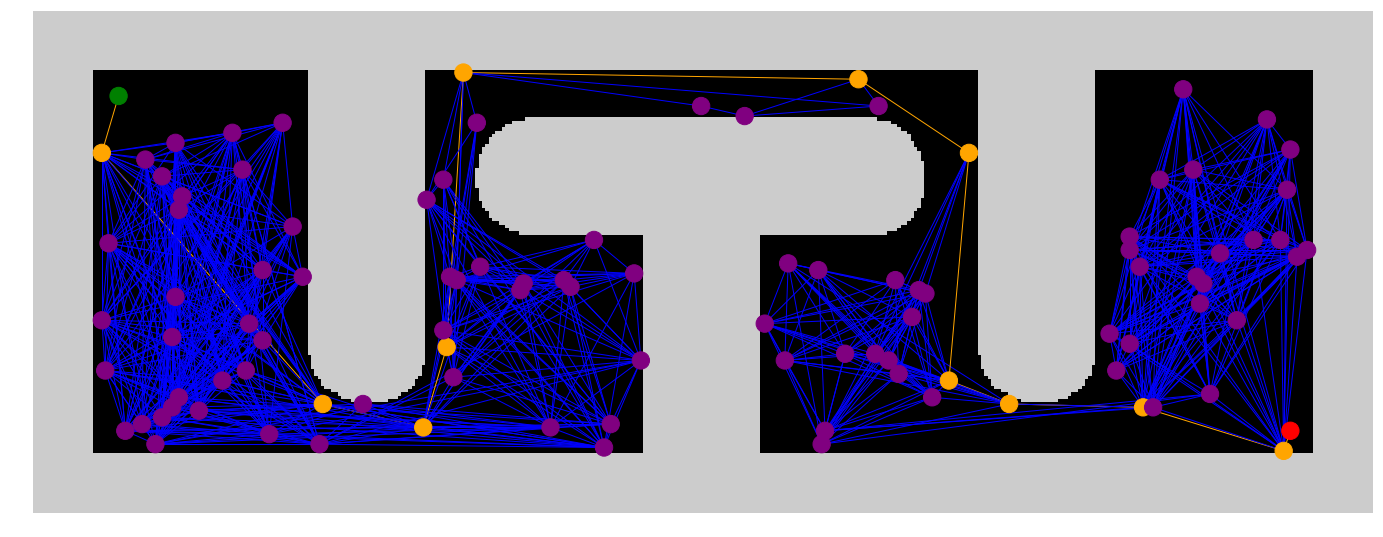

PRM Length:  591.1415029610863


In [72]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

pos = nx.get_node_attributes(G,'pos')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())
nodelist, node_color = zip(*nx.get_node_attributes(G,'color').items())

nx.draw(G, pos=pos, ax=ax, edgelist=edgelist, edge_color=edge_color, node_color=node_color)
plt.show()
print("PRM Length: ", length_prm_100_prob_prune)

For the case with 500 samples, we use a more aggressive pruning ratio of 98%.

In [73]:
n_samples = 500
samples = sample_points(config_space_2d_bool, n_samples)

ratio_prune = 0.98
n_prune = int((n_samples*(n_samples-1)/2)*ratio_prune)
G = build_prm_graph(config_space_2d_bool, samples, n_prune)

G, path, length_prm_500_prob_prune = query_prm(start, goal, map_2d=config_space_2d_bool, G=G)

Number of edges when completely connected:  124750
Number of edges after pruning:  2495


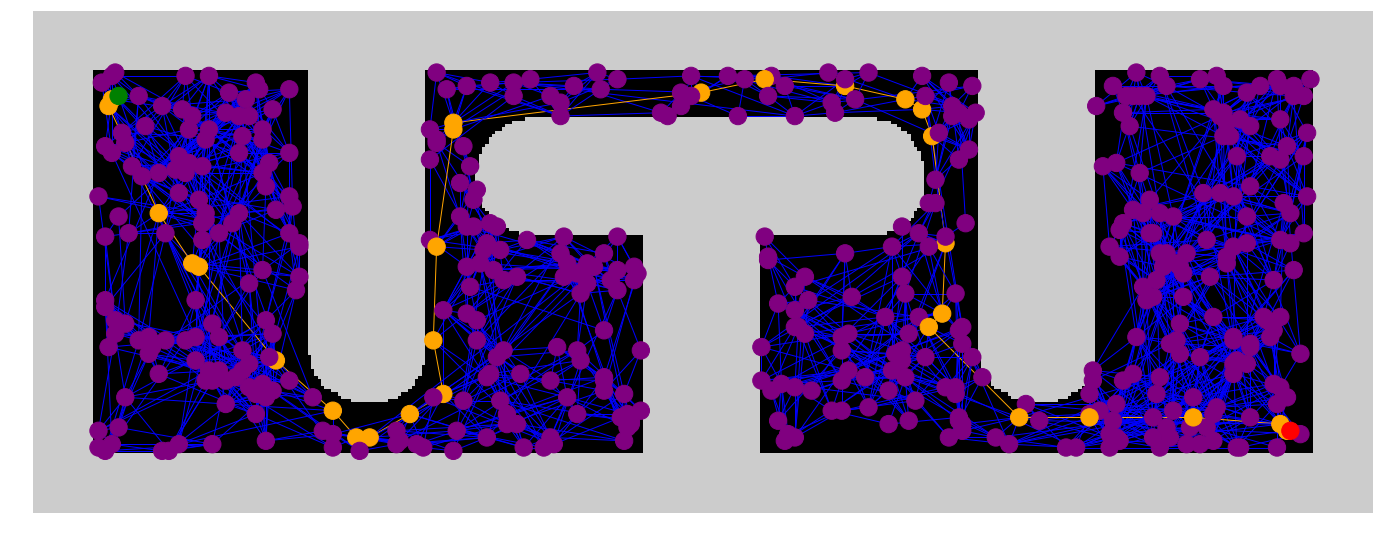

PRM Length:  570.698263078384


In [74]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

pos = nx.get_node_attributes(G,'pos')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())
nodelist, node_color = zip(*nx.get_node_attributes(G,'color').items())

nx.draw(G, pos=pos, ax=ax, edgelist=edgelist, edge_color=edge_color, node_color=node_color)
plt.show()
print("PRM Length: ", length_prm_500_prob_prune)

An alternate approach to pruning probabilistically is to simple remove the n  longest edges using a heap sort method. This has the added benefit that the only paths remaining are minimally short, and are thus also quick to compute collision checks. The geometric regularity of this approach also ensures that nearby points are more robustly connected, preventing unnecessary detours and circumnavigating nodes of close proximity. The downside however is that you are more likely to remove longer edges that could provide single shot shortcuts, or again, potentially bisect the road map graph; where the distances between the cuts of two subgraphs is relatively large In comparison to their inner edge distances.

In [75]:
n_samples = 500
samples = sample_points(config_space_2d_bool, n_samples)

ratio_prune = 0.95
n_prune = int((n_samples*(n_samples-1)/2)*ratio_prune)
G = build_prm_graph(config_space_2d_bool, samples, n_prune, prune_method=sample_edges_sorted)

G, path, length_prm_500_sorted_prune = query_prm(start, goal, map_2d=config_space_2d_bool, G=G)

Number of edges when completely connected:  124750
Number of edges after pruning:  6238


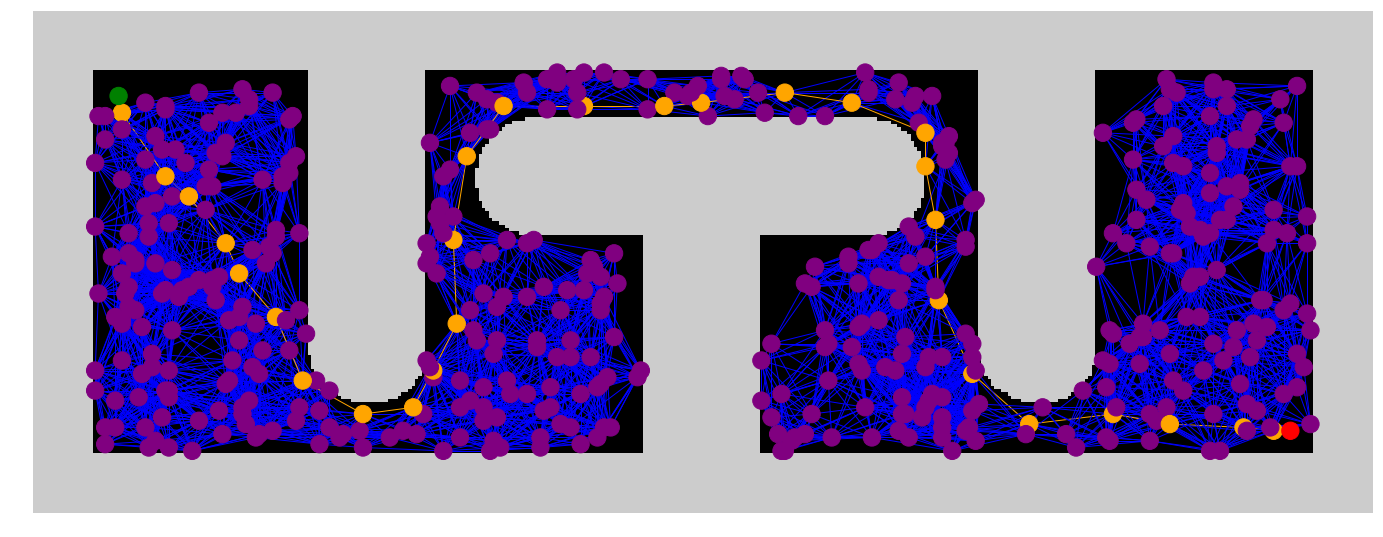

PRM Length:  539.3596836098676


In [76]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

pos = nx.get_node_attributes(G,'pos')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())
nodelist, node_color = zip(*nx.get_node_attributes(G,'color').items())

nx.draw(G, pos=pos, ax=ax, edgelist=edgelist, edge_color=edge_color, node_color=node_color)
plt.show()
print("PRM Length: ", length_prm_500_sorted_prune)

## 5. Rapid Exploring Random Trees

For our RRT, we can again use the configuration subspace has a quick collision look up table while we continue to sample free space points on the fly. When generating the tree from the sample points, will use a variant that is goal connect directed. This means that the pursuit of some sample will not be terminated prematurely due to some finite delta, but will instead extend as far as possible until the sample is reached for an obstacle is encountered.

This method here is also goal-directed given that with some probability the goal is selected as a candidate sample for extension, preferably at some larger degree then random subspace. The probabilistic bias towards the goal  is itself a trade-off question, where biasing towards the goal to much  can results and fruitless extensions into obstructing concave obstacles, or to little resulting in fruitless exploration of the entire subspace even after approaching the goal.

In [77]:
from scipy import spatial

class RRT_Goal_Connect():
    def __init__(self, start, goal, map_2d, goalBias = 0.05, rebalance=True):

        self.tree1 = nx.DiGraph()

        self.n_iters = 0
        self.n_extensions = 0

        self.start = start
        self.goal  = goal
        self.goal_found  = False
        self.map_2d = map_2d.copy()
        self.goalBias = goalBias
        self.rebalance = rebalance
        
        map_2d_flat = map_2d.flatten()
        map_2d_p = ((map_2d.flatten()-1)*-1).astype(np.int)
        self.map_2d_p = map_2d_p/map_2d_p.sum()
        self.map_2d_ix = np.arange(0, map_2d_flat.size)
        
        self.tree1.add_node(tuple(self.start), state=self.start)
    
    def nearest_neighbor(self, tree, state):
        node_so_far = None
        distance_so_far = None
        for this_node, this_data in tree.nodes(data=True):
            this_distance = self.distance(this_data['state'], state) 
            if(distance_so_far is None):
                distance_so_far = this_distance
                node_so_far = this_node
            elif(distance_so_far > this_distance):
                node_so_far = this_node
                distance_so_far = this_distance
        return (node_so_far,distance_so_far)
    
    def search(self,iters=500):
        for i in range(iters):
            self.n_iters += 1
            if (np.random.rand() <= self.goalBias):
                q_rand = self.goal
            else:
                q_rand = self.sample()
            self.extend(q_rand)
            if self.goal_found:
                print("Goal found!")
                print("Iterations taken: ", i)
                return True
        print("No goal found...")
        print("Iterations taken: ", iters)
        return False
    
    def extend(self,q_rand):
        self.n_extensions += 1
        tree = self.tree1

        q_nearest_id, q_nearest_distance  = self.nearest_neighbor(tree, q_rand)
        x_new_id = self.extend_from(tree, q_nearest_id, q_nearest_distance, q_rand)
    
    def extend_from(self, tree, q_nearest_id, q_nearest_distance, q_rand):
        q_near = tree.node[q_nearest_id]['state']
        trajectory = measure.profile_line(self.map_2d, q_near, q_rand)
        if trajectory.any():
            if trajectory[0] or trajectory[1]:
                # pointed up against a wall, just ignore it
                return
            else:
                stop_point = np.argmax(trajectory)
                delta = (q_rand - q_near)*(stop_point/len(trajectory))
                q_new = q_near + np.floor(delta).astype(np.int)
                print(self.n_extensions, " Bumbed wall: ", q_new)
        else:
            q_new = q_rand
        
        tree.add_node(tuple(q_new), state=q_new)
        q_new_distance = self.distance(q_near, q_new)
        tree.add_edge(tuple(q_near), tuple(q_new), color='blue', distance=q_new_distance)
        self.check_goal(tree, tuple(q_new))
        
    def best_solution(self, tree, state):
        goal_id = self.nearest_neighbor(tree, state)[0]
        path = nx.shortest_path(tree, source=goal_id, target=tuple(self.goal))
        length = nx.shortest_path_length(tree, source=goal_id, target=tuple(self.goal), weight='distance')
        return path, length
    
    
    def check_goal(self, tree, node_id):
        self.goal_found = np.array_equal(self.goal, tree.node[node_id]['state'])
    
    def sample(self):
        """
        sample() returns point in state space
        """
        sample_1d_ix = np.random.choice(self.map_2d_ix, 1, replace=False, p=self.map_2d_p)
        sample_nd_ix = np.array(np.unravel_index(sample_1d_ix, self.map_2d.shape))
        q_rand = sample_nd_ix.flatten()
        if self.rebalance:
            self.map_2d_p[sample_1d_ix] = 0
            self.map_2d_p = self.map_2d_p*(1/self.map_2d_p.sum())
        return q_rand
    
    def distance(self,u,v):
        """
        distance(from_node,to_point)
        """
        return spatial.distance.euclidean(u, v)

In [78]:
rrt_goal_connect = RRT_Goal_Connect(start, goal, config_space_2d_bool, goalBias=0.05)
rrt_goal_connect.search(10000)

2  Bumbed wall:  [82 87]
103  Bumbed wall:  [182 114]
146  Bumbed wall:  [133  58]
149  Bumbed wall:  [155  65]
278  Bumbed wall:  [281  30]
295  Bumbed wall:  [116 104]
323  Bumbed wall:  [282  98]
476  Bumbed wall:  [266  55]
Goal found!
Iterations taken:  568


True

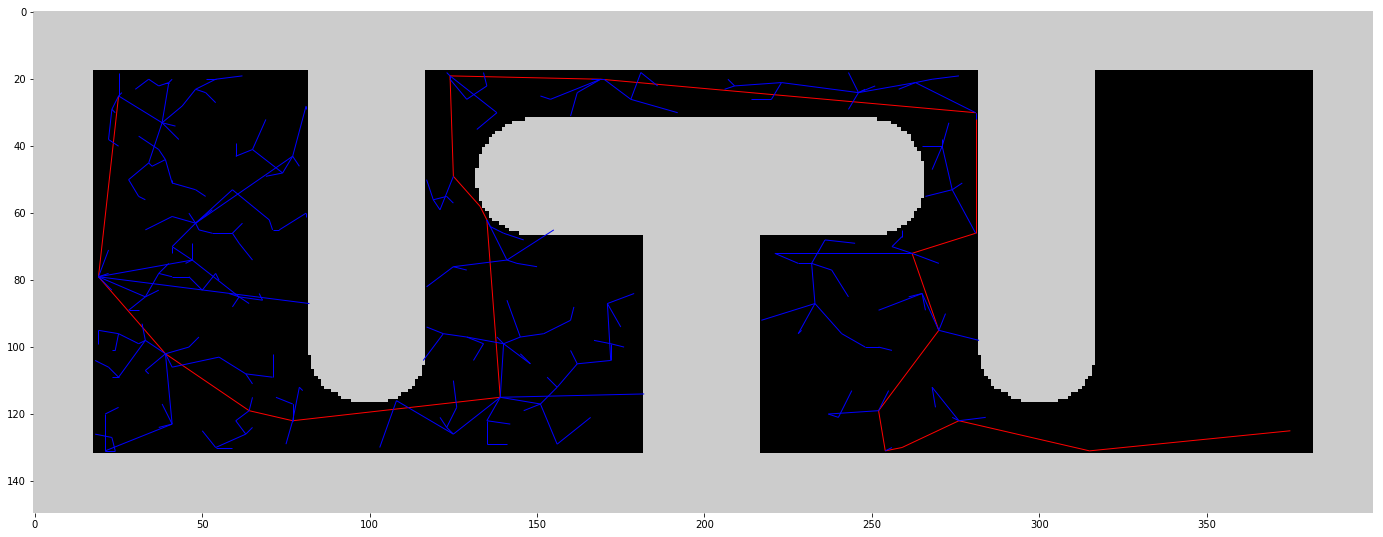

RRT Length:  694.5711277181326


In [79]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

G = rrt_goal_connect.tree1
G = G.to_undirected()

path, length_rrt_rebalance = rrt_goal_connect.best_solution(rrt_goal_connect.tree1, start)
G_path = G.subgraph(path)
for u, v, data in G_path.edges(data=True):
    data['color'] = 'red'

pos = nx.get_node_attributes(G,'state')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())

nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=edge_color)
plt.show()
print("RRT Length: ", length_rrt_rebalance)

The RRT method above also Brain balances the sample space after each sample. because we're working with a discretize space, we can avoid double sampling By waiting be extended coordinates as such to remove them from the sample pool. this speeds of computation a little and also prevents the tree from becoming unnecessarily dense near the starting point of the tree. Below is an example with Rebalancing disabled, note the dense foliage near the root of the tree.

In [80]:
rrt_goal_connect = RRT_Goal_Connect(start, goal, config_space_2d_bool, goalBias=0.05, rebalance=False)
rrt_goal_connect.search(10000)

4  Bumbed wall:  [82 59]
13  Bumbed wall:  [82 90]
63  Bumbed wall:  [182  91]
118  Bumbed wall:  [133  55]
167  Bumbed wall:  [163  65]
290  Bumbed wall:  [182 130]
402  Bumbed wall:  [182  68]
763  Bumbed wall:  [243  32]
2001  Bumbed wall:  [282  41]
2460  Bumbed wall:  [264  45]
2882  Bumbed wall:  [281  20]
3044  Bumbed wall:  [257  33]
3916  Bumbed wall:  [282  70]
3970  Bumbed wall:  [291 114]
Goal found!
Iterations taken:  4239


True

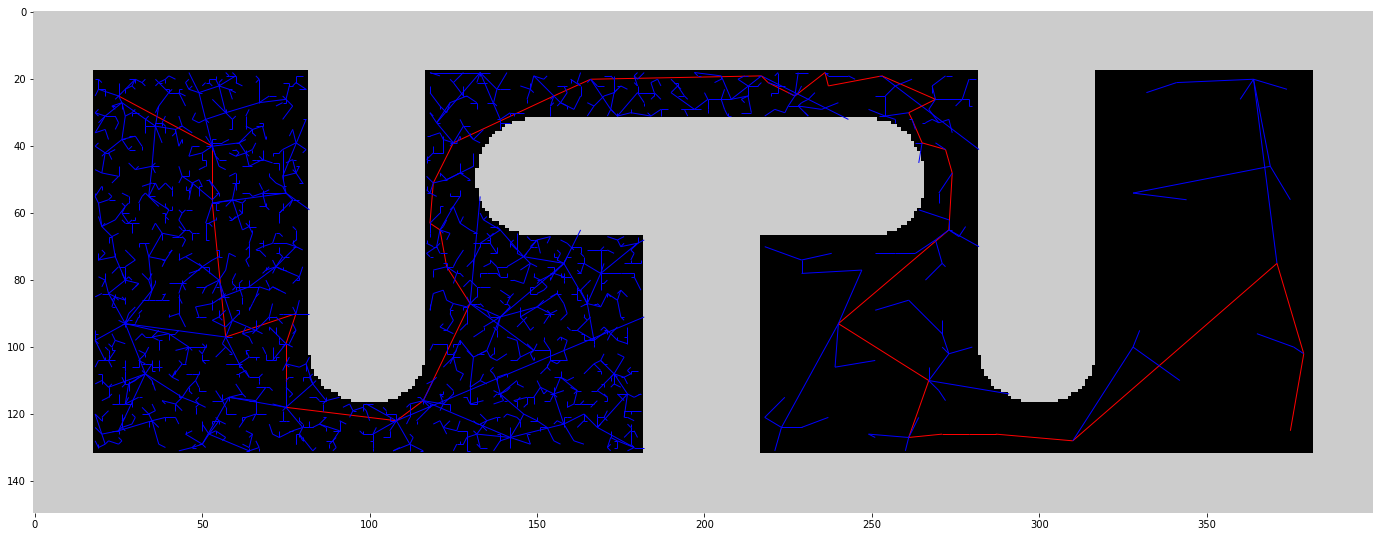

RRT Length:  750.6010632020418


In [81]:
fig = plot_map_2d(config_space_2d_bool, hold=True)
ax = fig.get_axes()[0]

G = rrt_goal_connect.tree1
G = G.to_undirected()

path, length_rrt_no_rebalance = rrt_goal_connect.best_solution(rrt_goal_connect.tree1, start)
G_path = G.subgraph(path)
for u, v, data in G_path.edges(data=True):
    data['color'] = 'red'

pos = nx.get_node_attributes(G,'state')
edgelist, edge_color = zip(*nx.get_edge_attributes(G,'color').items())

nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=edge_color)
plt.show()
print("RRT Length: ", length_rrt_no_rebalance)

## Summery

From the summarizing table below, we find that greedy based search methods for discretized configuration spaces provide a tighter upper bound on optimal trajectories and can computed quite fast when leverage the symmetrical structure of the search space. Voronoi Partitioning can also be computed quite fast and can be solved for even quicker due to its narrowed scope in reachability,  however results and longer found paths due to its conservative nature.

PRMs offer another fast method when correctly tuned with appropriate pruning parameters given that the configuration space is known beforehand and can be  sufficiently sampled, where path optimality is often proportional to sample density/ coverage. However, if the configuration space is not known beforehand, a more exploratory method such as RRTs provide useful search method for expanding out from a known start point and into an uncertain environment. The search domain here, given the configuration space was discreet and completely known, does not necessarily play to RRT strengths where normally the configuration space would only need to be sparsely computed during online exploration, but can still be made applicable with offline lookups.

In [83]:
import tabulate
table = [["A*/JPS conservative",538.232539],
         ["A*/JPS optimistic", 503.587878],
         ["voronoi partitions", 669.470129],
         ["length_prm_50",length_prm_50],
         ["length_prm_100_prob_prune", length_prm_100_prob_prune],
         ["length_prm_500_prob_prune", length_prm_500_prob_prune],
         ["length_prm_500_sorted_prune", length_prm_500_sorted_prune],
         ["length_rrt_rebalance", length_rrt_rebalance],
         ["length_rrt_no_rebalance", length_rrt_no_rebalance]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

|Method | Distance|
|--|--|
|A*/JPS conservative | 	538.233|
|A*/JPS optimistic |	503.588|
|voronoi partitions |	669.47|
|length_prm_50 |	576.2|
|length_prm_100_prob_prune |	591.142|
|length_prm_500_prob_prune |	570.698|
|length_prm_500_sorted_prune |	539.36|
|length_rrt_rebalance |	694.571|
|length_rrt_no_rebalance |	750.601|